# Tarea 3

Objetivo
Ejecutar el proceso de extracción de datos y entrenamiento de un modelo en Apache Spark de principio a fin

Para esta tarea utilizare un conjunto de datos relacionado con la predicción de Online Payments Fraud Detection, que se puede descargar desde https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Estudiante: Valeria Garro Abarca

# Descripcion del Dataset y Objetivo (5 puntos)


## 2.1 Dominio del Problema
El dominio del problema es la **Detección de Fraude en Pagos en Línea (Online Payments Fraud Detection)**. El objetivo es construir un modelo de **clasificación binaria** para predecir si una transacción financiera, dentro de un gran conjunto de datos (aproximadamente 6.3 millones de registros), es fraudulenta o legítima.

Este es un problema desafiante de **Big Data** ideal para Spark, debido a:
1.  **Magnitud de los Datos:** El gran volumen de transacciones justifica el uso de un *framework* distribuido como Spark, cumpliendo con el requisito de basarse en **infraestructura Spark y no en código secuencial hecho en Python**.
2.  **Clases Desequilibradas:** El fraude es un evento raro (clase minoritaria), lo que requerirá una **evaluación rigurosa** con métricas como el **área bajo la curva ROC**, tal como se solicita en la tarea.

## 2.2 Variable de Predicción a Utilizar
La variable objetivo ($y$) a predecir es: **`isFraud`** (Fraude: 1, Legítimo: 0).

## 2.3 Descripción de Atributos Clave
El dataset contiene las siguientes columnas principales:

| Atributo (Columna) | Tipo de Dato | Descripción |
| :--- | :--- | :--- |
| **`step`** | Numérico | Unidad de tiempo en la simulación (1 *step* = 1 hora). |
| **`type`** | Categórico | Tipo de transacción (`CASH_OUT`, `PAYMENT`, `TRANSFER`, etc.). |
| **`amount`** | Numérico | Monto de la transacción. |
| **`nameOrig`** | Categórico (ID) | ID del cliente que inicia la transacción (origen). |
| **`oldbalanceOrg`** | Numérico | Saldo del cliente origen **antes** de la transacción. |
| **`newbalanceOrig`** | Numérico | Saldo del cliente origen **después** de la transacción. |
| **`nameDest`** | Categórico (ID) | ID del destinatario de la transacción. |
| **`oldbalanceDest`** | Numérico | Saldo del destinatario **antes** de la transacción. |
| **`newbalanceDest`** | Numérico | Saldo del destinatario **después** de la transacción. |
| **`isFraud`** | **Binario (Target)** | **Etiqueta (Target):** 1 si es fraude, 0 si es legítimo. |
| **`isFlaggedFraud`** | Binario | Indicador establecido por el sistema de monitoreo anterior (1 si es sospechoso, 0 si no). |




# Subsampling
 El detaset original PS_20174392719_1491204439457_log.csv tiene 6362620 records. Para facilitar el manejo del dataset extraje un subsample de 200000 subsample_200000_records.csv que utilizare para la tarea.

In [1]:
# --- Configuración Inicial ---
import findspark
# Inicializa Spark 
findspark.init() 

# --- Librerías Estándar para Plotting y Manejo de Datos ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

# --- PySpark Core y Tipos de Datos (SQL/DataFrame) ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit, mean, sum
from pyspark.sql.types import (
    StringType, 
    IntegerType,
    DoubleType,
    StructField, 
    StructType
)

# --- PySpark Machine Learning (MLlib) ---
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Lectura y limpieza (5 puntos)
En las celdas siguientes leeremos los datos de un archivo CSV y realizaremos diferentes pasos para poder cargar los datos a una tabla en PostgreSQL que almacenará el conjunto de datos en su forma deseada para abordar el análisis.

In [2]:
# Configuración de Spark Session incluyendo el driver de PostgreSQL
spark = SparkSession \
    .builder \
    .appName("Tarea3_FraudDetection") \
    .config("spark.driver.extraClassPath", "./db/postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "./db/postgresql-42.2.14.jar") \
    .getOrCreate()

# Definición del Schema (5 puntos)
schema = StructType([
    StructField("step", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("amount", DoubleType(), True),
    StructField("nameOrig", StringType(), True),
    StructField("oldbalanceOrg", DoubleType(), True),
    StructField("newbalanceOrig", DoubleType(), True),
    StructField("nameDest", StringType(), True),
    StructField("oldbalanceDest", DoubleType(), True),
    StructField("newbalanceDest", DoubleType(), True),
    StructField("isFraud", IntegerType(), True), # Variable Target (Binaria: 0 o 1)
    StructField("isFlaggedFraud", IntegerType(), True)
])

# Cargado de Datos y Muestra
file_path = "subsample_balanced_20000_records.csv" 
# file_path = "PS_20174392719_1491204439457_log.csv"

try:
    df_raw = spark \
        .read \
        .format("csv") \
        .option("path", file_path) \
        .option("header", True) \
        .schema(schema) \
        .load()
    
    print("✅ Datos cargados exitosamente.")
    
    print("\n📋 Schema del DataFrame (Evidencia de schema):")
    df_raw.printSchema()
    
    print("\n📋 Muestra de los datos (Evidencia de carga):")
    df_raw.show(5)
    
except Exception as e:
    print(f"❌ ERROR: Asegúrate de que el archivo '{file_path}' esté disponible y el driver JDBC esté configurado. Detalle del error: {e}")


df_raw.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/03 02:59:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Datos cargados exitosamente.

📋 Schema del DataFrame (Evidencia de schema):
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)


📋 Muestra de los datos (Evidencia de carga):


[Stage 0:>                                                          (0 + 1) / 1]

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  34|CASH_OUT|381324.11| C250409036|    237725.49|           0.0|     C95137|    2062322.67|    2443646.78|      0|             0|
| 288|CASH_OUT| 28636.24|C1938848302|     28636.24|           0.0|C1653587362|       24561.4|      53197.64|      1|             0|
|  43| PAYMENT|  3821.64| C551550619|    153114.07|     149292.42|M1374221238|           0.0|           0.0|      0|             0|
| 386|CASH_OUT|442290.23| C619581802|    442290.23|           0.0|C2040999493|           0.0|     442290.23|      1|             0|
|  34|TRANSFER| 419155.7|C1967524064|      24750.0|           0.0| C82621462

# Análisis Descriptivo (10 puntos)

In [3]:
df_raw.describe().show()
df_raw.groupBy("type").agg(mean("amount").alias("avg_amount")).show()
df_raw.groupBy("type").agg(sum(col("isFraud").cast("integer")).alias("total_fraud")).show()


25/11/03 02:59:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------+-----------------+--------+------------------+-----------+------------------+-----------------+-----------+-----------------+------------------+------------------+--------------------+
|summary|             step|    type|            amount|   nameOrig|     oldbalanceOrg|   newbalanceOrig|   nameDest|   oldbalanceDest|    newbalanceDest|           isFraud|      isFlaggedFraud|
+-------+-----------------+--------+------------------+-----------+------------------+-----------------+-----------+-----------------+------------------+------------------+--------------------+
|  count|            20000|   20000|             20000|      20000|             20000|            20000|      20000|            20000|             20000|             20000|               20000|
|   mean|        293.87545|    NULL| 694932.3384144994|       NULL|1164621.5310395046|594008.0299149979|       NULL|874736.1773525007|1240966.9542474973|               0.4|              8.0E-4|
| stddev|185.9174007490766|   

+--------+------------------+
|    type|        avg_amount|
+--------+------------------+
|TRANSFER| 1377063.505933262|
| CASH_IN|168468.99778241094|
|CASH_OUT| 795395.5115228638|
| PAYMENT| 13038.48462050272|
|   DEBIT| 4079.732222222222|
+--------+------------------+



[Stage 7:>                                                          (0 + 1) / 1]

+--------+-----------+
|    type|total_fraud|
+--------+-----------+
|TRANSFER|       3985|
| CASH_IN|          0|
|CASH_OUT|       4015|
| PAYMENT|          0|
|   DEBIT|          0|
+--------+-----------+



Matriz de Correlación

25/11/03 02:59:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

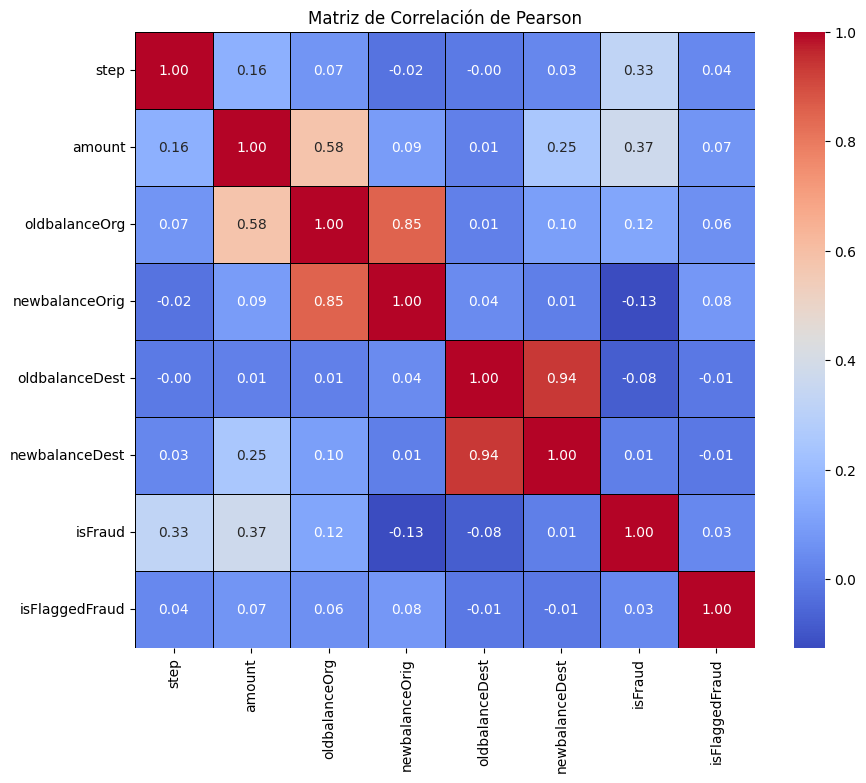

In [4]:
# Columnas numéricas a incluir en la matriz de correlación
numeric_cols = [
    'step', 
    'amount', 
    'oldbalanceOrg', 
    'newbalanceOrig', 
    'oldbalanceDest', 
    'newbalanceDest', 
    'isFraud', 
    'isFlaggedFraud'
]

# Crear un VectorAssembler para combinar las columnas numéricas en un solo vector
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol='features_vector'
)

# Aplicar la transformación
vector_df = assembler.transform(df_raw).select('features_vector')

# Calcular la matriz de correlación de Pearson
pearson_matrix_row = Correlation.corr(vector_df, 'features_vector').collect()[0][0]

# Convertir la matriz de Spark a una matriz de Pandas para la visualización con Seaborn
pearson_matrix = pd.DataFrame(pearson_matrix_row.toArray(), index=numeric_cols, columns=numeric_cols)

# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            linewidths=.5, 
            linecolor='black')
plt.title('Matriz de Correlación de Pearson')
plt.show()

Total de Transacciones Fraudulentas por Tipo:


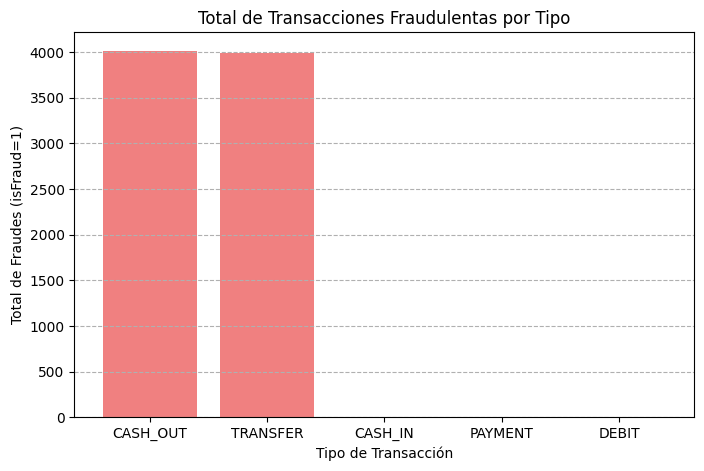


 Monto Promedio de Transacción por Tipo:


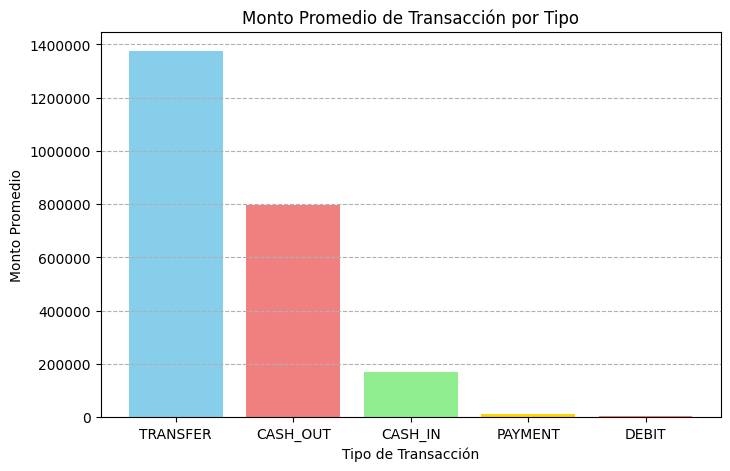

In [5]:
# ---- Gráfico 1: Total de Fraude por Tipo de Transacción ----
print("Total de Transacciones Fraudulentas por Tipo:")

# Agrupar y convertir a Pandas para graficar
df_fraud_by_type = df_raw.groupBy("type") \
                           .agg(sum(col("isFraud").cast("integer")).alias("total_fraud")) \
                           .toPandas()

# Ordenar para mejor visualización
df_fraud_by_type = df_fraud_by_type.sort_values(by='total_fraud', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_fraud_by_type['type'], df_fraud_by_type['total_fraud'], color=['lightcoral' if f > 0 else 'lightgray' for f in df_fraud_by_type['total_fraud']])
plt.title('Total de Transacciones Fraudulentas por Tipo')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Total de Fraudes (isFraud=1)')
plt.grid(axis='y', linestyle='--')
plt.show()

# ---- Gráfico 2: Monto Promedio por Tipo de Transacción ----
print("\n Monto Promedio de Transacción por Tipo:")

# Agrupar y convertir a Pandas para graficar
df_avg_amount_by_type = df_raw.groupBy("type") \
                                .agg(mean("amount").alias("avg_amount")) \
                                .toPandas()
                                
# Ordenar para mejor visualización
df_avg_amount_by_type = df_avg_amount_by_type.sort_values(by='avg_amount', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_avg_amount_by_type['type'], df_avg_amount_by_type['avg_amount'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'salmon'])
plt.title('Monto Promedio de Transacción por Tipo')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Monto Promedio')
plt.grid(axis='y', linestyle='--')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Distribución de Frecuencia de la Variable isFraud (Pie Chart)

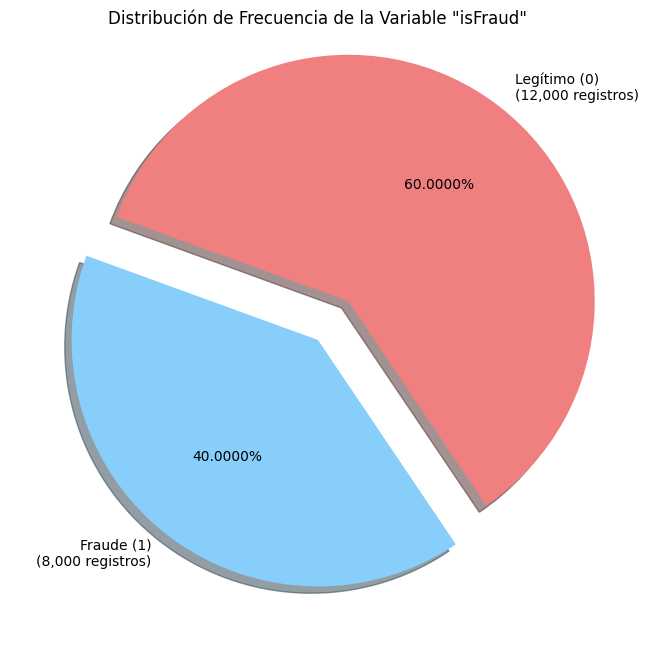

In [6]:
# Calcular los conteos de la variable 'isFraud'
df_isFraud_counts = df_raw.groupBy("isFraud").count().toPandas()

# Renombrar las columnas para mejor lectura
df_isFraud_counts['isFraud'] = df_isFraud_counts['isFraud'].astype(str).replace({
    '0': 'Legítimo (0)', 
    '1': 'Fraude (1)'
})

# Preparar datos para el gráfico
sizes = df_isFraud_counts['count']
labels = df_isFraud_counts.apply(lambda x: f"{x['isFraud']}\n({x['count']:,} registros)", axis=1)
colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.2)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.4f%%', shadow=True, startangle=160)
plt.title('Distribución de Frecuencia de la Variable "isFraud"')
plt.show()

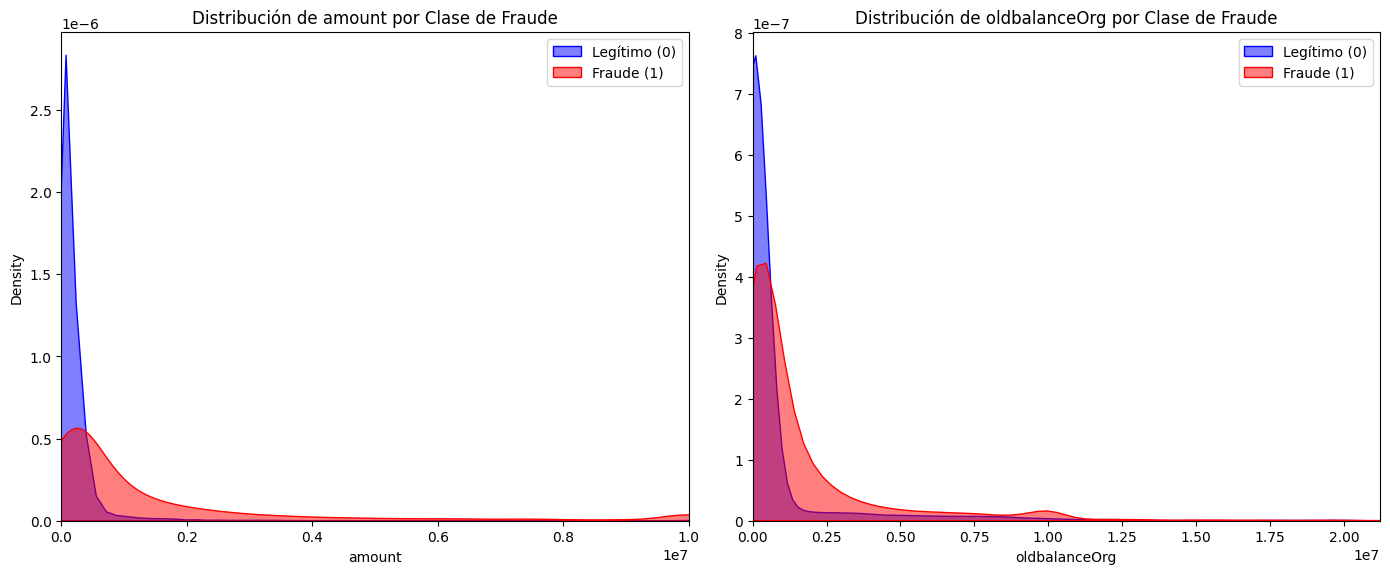

In [7]:
df_sample_pandas = df_raw.toPandas()

# Definir las variables a graficar
variables = ['amount', 'oldbalanceOrg']

plt.figure(figsize=(14, 6))

for i, var in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    
    # Graficar la distribución de densidad (KDE) para la clase 0 (Legítimo)
    sns.kdeplot(df_sample_pandas[df_sample_pandas['isFraud'] == 0][var], 
                label='Legítimo (0)', color='blue', fill=True, alpha=0.5, bw_adjust=1)
    
    # Graficar la distribución de densidad (KDE) para la clase 1 (Fraude)
    # Nota: Los datos de fraude están muy sesgados, la curva podría ser muy plana o no aparecer
    sns.kdeplot(df_sample_pandas[df_sample_pandas['isFraud'] == 1][var], 
                label='Fraude (1)', color='red', fill=True, alpha=0.5, bw_adjust=1)

    plt.title(f'Distribución de {var} por Clase de Fraude')
    plt.xlabel(var)
    # Limitar el eje X al percentil 99 para excluir outliers muy extremos y ver mejor la concentración
    plt.xlim(0, df_sample_pandas[var].quantile(0.995)) 
    plt.legend()

plt.tight_layout()
plt.show()

# Preprocesamiento de Datos (10 puntos)

In [8]:
# Columnas numéricas que serán ensambladas y escaladas.
numeric_cols_to_scale = [
    'step', 
    'amount', 
    'oldbalanceOrg', 
    'newbalanceOrig', 
    'oldbalanceDest', 
    'newbalanceDest'
]
categorical_col = 'type'
TYPE_LABELS = ['TRANSFER', 'CASH_IN', 'CASH_OUT', 'PAYMENT', 'DEBIT']


# --- Definición de Etapas de Preprocesamiento de Spark (Pipeline) ---

# A. Codificación de 'type'
indexer = StringIndexer(inputCol=categorical_col, outputCol="type_index")
encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")

# B. Estandarización de columnas numéricas  
scaler_assembler = VectorAssembler(inputCols=numeric_cols_to_scale, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features",
                        withStd=True, withMean=False) 

# El Pipeline se detiene aquí, antes de ensamblar el vector final de features.
pipeline = Pipeline(stages=[indexer, encoder, scaler_assembler, scaler])


# --- Ejecución y Descomposición de Vectores ---

print(" Ejecutando Pipeline y transformando datos...")
pipeline_model = pipeline.fit(df_raw)
df_transformed = pipeline_model.transform(df_raw)


# UDF: Función para extraer el valor de una posición específica de un Vector de MLlib.
# Se usa para descomponer el Vector de nuevo en columnas atómicas.
def get_vector_value(vector, index):
    if vector is not None and index < vector.size:
        return float(vector.toArray()[index]) 
    return 0.0

get_vector_value_udf = udf(get_vector_value, DoubleType())

# Descomponer los vectores intermedios en el DataFrame final
df_db_ready = df_transformed

# Descomponer el vector numérico escalado ('scaled_numeric_features')
for i, col_name in enumerate(numeric_cols_to_scale):
    df_db_ready = df_db_ready.withColumn(
        f"scaled_{col_name}", 
        get_vector_value_udf(col("scaled_numeric_features"), lit(i))
    )

# Descomponer el vector OHE ('type_encoded')
for i, type_label in enumerate(TYPE_LABELS):
    df_db_ready = df_db_ready.withColumn(
        f"is_{type_label}_ohe", 
        get_vector_value_udf(col("type_encoded"), lit(i))
    )


# --- Creación del DataFrame Final y Escritura a BD ---

# Definición de las columnas finales a guardar 
final_cols_to_save = [col("isFraud").cast(IntegerType()).alias("isFraud")] 
for col_name in numeric_cols_to_scale:
    final_cols_to_save.append(col(f"scaled_{col_name}"))

for type_label in TYPE_LABELS:
    final_cols_to_save.append(col(f"is_{type_label}_ohe"))

# DataFrame final solo con columnas atómicas
df_final_non_vector = df_db_ready.select(final_cols_to_save)

print("DataFrame descompuesto en columnas individuales listo para la BD.")
print("\n Schema del DataFrame para DB:")
df_final_non_vector.printSchema()



 Ejecutando Pipeline y transformando datos...
DataFrame descompuesto en columnas individuales listo para la BD.

 Schema del DataFrame para DB:
root
 |-- isFraud: integer (nullable = true)
 |-- scaled_step: double (nullable = true)
 |-- scaled_amount: double (nullable = true)
 |-- scaled_oldbalanceOrg: double (nullable = true)
 |-- scaled_newbalanceOrig: double (nullable = true)
 |-- scaled_oldbalanceDest: double (nullable = true)
 |-- scaled_newbalanceDest: double (nullable = true)
 |-- is_TRANSFER_ohe: double (nullable = true)
 |-- is_CASH_IN_ohe: double (nullable = true)
 |-- is_CASH_OUT_ohe: double (nullable = true)
 |-- is_PAYMENT_ohe: double (nullable = true)
 |-- is_DEBIT_ohe: double (nullable = true)



Escritura a base de datos (10 puntos)

In [9]:
# Escritura a Base de Datos 

# Configuración JDBC
DB_TABLE = "tarea3" 
JDBC_URL = "jdbc:postgresql://host.docker.internal:5433/postgres"
JDBC_USER = "postgres"
JDBC_PASSWORD = "testPassword"
JDBC_DRIVER = "org.postgresql.Driver"

print(f"\n Almacenando el conjunto de datos limpio en PostgreSQL en la tabla: {DB_TABLE}...")

try:
    df_final_non_vector \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", JDBC_URL) \
        .option("dbtable", DB_TABLE) \
        .option("user", JDBC_USER) \
        .option("password", JDBC_PASSWORD) \
        .option("driver", JDBC_DRIVER) \
        .save()
    
    print(f"✅ DataFrame guardado exitosamente en la tabla: {DB_TABLE}")

except Exception as e:
    print(f"❌ ERROR al intentar escribir en PostgreSQL: {e}")


 Almacenando el conjunto de datos limpio en PostgreSQL en la tabla: tarea3...


✅ DataFrame guardado exitosamente en la tabla: tarea3


# Inspección de datos
Previo a entrenar el modelo es común que se realice algún tipo de descripción de los datos, para tener una idea del tipo de problema con el que nos enfrentamos. A continuación, algunas operacions útiles que podemos usar.


In [10]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df.show()

+-------+-------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------+--------------+---------------+--------------+------------+
|isFraud|        scaled_step|       scaled_amount|scaled_oldbalanceOrg|scaled_newbalanceOrig|scaled_oldbalanceDest|scaled_newbalanceDest|is_TRANSFER_ohe|is_CASH_IN_ohe|is_CASH_OUT_ohe|is_PAYMENT_ohe|is_DEBIT_ohe|
+-------+-------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------+--------------+---------------+--------------+------------+
|      0|0.18287691126818245|  0.2243734673976514| 0.07404539340213698|                  0.0|   0.6021484130407085|   0.6490608128219604|            1.0|           0.0|            0.0|           0.0|         0.0|
|      1| 1.5490750130951927|0.016849740925196997|0.008919454351983925|                  0.0| 0.007171335624244512| 0.014129907702376706|           

In [11]:
# Información descriptiva del dataframe.
df.describe().show()
print(df.columns)

[Stage 35:>                                                         (0 + 1) / 1]

+-------+------------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+------------------+------------------+-----------------+-------------------+------------+
|summary|           isFraud|         scaled_step|     scaled_amount|scaled_oldbalanceOrg|scaled_newbalanceOrig|scaled_oldbalanceDest|scaled_newbalanceDest|   is_TRANSFER_ohe|    is_CASH_IN_ohe|  is_CASH_OUT_ohe|     is_PAYMENT_ohe|is_DEBIT_ohe|
+-------+------------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+------------------+------------------+-----------------+-------------------+------------+
|  count|             20000|               20000|             20000|               20000|                20000|                20000|                20000|             20000|             20000|            20000|              20000|       20000|
|   mean|           

In [12]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
assembler = VectorAssembler(
    inputCols=['scaled_step', 'scaled_amount', 'scaled_oldbalanceOrg', 'scaled_newbalanceOrig', 'scaled_oldbalanceDest', 'scaled_newbalanceDest',
               'is_TRANSFER_ohe', 'is_CASH_IN_ohe', 'is_CASH_OUT_ohe', 'is_PAYMENT_ohe', 'is_DEBIT_ohe'],
    outputCol='features')

vector_df = assembler.transform(df)
df_model_data = vector_df.select(['features', 'isFraud'])
df_model_data.show()


[Stage 38:>                                                         (0 + 1) / 1]

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|(11,[0,1,2,4,5,6]...|      0|
|(11,[0,1,2,4,5,6]...|      1|
|(11,[0,1,2,3,8],[...|      0|
|(11,[0,1,2,5,6],[...|      1|
|(11,[0,1,2,4,5,7]...|      0|
|(11,[0,1,4,5,6],[...|      0|
|(11,[0,1,2,3,8],[...|      0|
|(11,[0,1,2,4,5,6]...|      1|
|(11,[0,1,4,5,6],[...|      0|
|[0.71537144701965...|      0|
|(11,[0,1,2,7],[1....|      1|
|(11,[0,1,2,4,5,6]...|      1|
|(11,[0,1,2,4,5,6]...|      0|
|[0.03765112879050...|      0|
|(11,[0,1,8],[2.15...|      0|
|(11,[0,1,2,7],[1....|      1|
|[1.63513473604492...|      0|
|(11,[0,1,2,3,8],[...|      0|
|(11,[0,1,4,5,6],[...|      0|
|(11,[0,1,2,7],[3....|      1|
+--------------------+-------+
only showing top 20 rows


25/11/03 03:00:22 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


<Axes: >

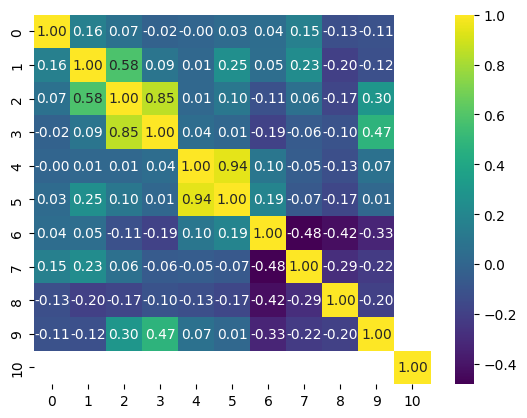

In [13]:
# Con la representación de vectores podemos calcular correlaciones
pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Modelos de classificacion


In [14]:
# Dividir el dataset: 80% para entrenamiento/CV y 20% para validación final.
train_cv_df, validation_df = df_model_data.randomSplit([0.8, 0.2], seed=42)

print(f"Total de datos para Entrenamiento/Cross-Validation: {train_cv_df.count()}")
print(f"Total de datos para Validación Final: {validation_df.count()}")

# ---Configuración del Evaluador para Clasificación Binaria ---
# Utiliamos el AUC-ROC como métrica principal
evaluator = BinaryClassificationEvaluator(
    labelCol="isFraud", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

Total de datos para Entrenamiento/Cross-Validation: 16052


[Stage 46:>                                                         (0 + 1) / 1]

Total de datos para Validación Final: 3948


## Modelo 1: Regresión Logística (Logistic Regression)

In [15]:

# =================================================================
# Entrenamiento del Modelo 1: Regresión Logística 
# =================================================================

print("\n Entrenando Modelo 1: Regresión Logística con K-fold Cross Validation...")
lr = LogisticRegression(featuresCol="features", labelCol="isFraud", family="binomial", maxIter=10)

# Grid de Parámetros: Probando diferentes niveles de regularización
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .build()

cross_val_lr = CrossValidator(estimator=lr, # Modelo base de Regresión Logística
                              estimatorParamMaps=lr_paramGrid, # Conjunto de hiperparámetros a probar
                              evaluator=evaluator, # Metrics de evaluación (AUC-ROC)
                              numFolds=3, # 3-fold CV
                              seed=42) 

# Ajustar (entrenar) el modelo con CV
lr_model = cross_val_lr.fit(train_cv_df) # Le pasamos solo el conjunto de entrenamiento/CV
best_lr_model = lr_model.bestModel # Devuelve el modelo con el conjunto de hiperparámetros que logró el mejor promedio de AUC-ROC a través de los k-folds

print(" Entrenamiento de Regresión Logística Completado.")
print(f"Mejor AUC-ROC en CV: {max(lr_model.avgMetrics)}")


 Entrenando Modelo 1: Regresión Logística con K-fold Cross Validation...


 Entrenamiento de Regresión Logística Completado.
Mejor AUC-ROC en CV: 0.9513103846731146


## Modelo 2: Clasificador de Bosque Aleatorio (Random Forest Classifier)

In [16]:

# =================================================================
# Entrenamiento del Modelo 2: Random Forest Classifier 
# =================================================================

print("\n Entrenando Modelo 2: Random Forest con K-fold Cross Validation...")
rf = RandomForestClassifier(featuresCol="features", labelCol="isFraud", seed=42)

# Grid de Parámetros: Probando diferentes profundidades y número de árboles
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [10, 20]) \
    .build()

cross_val_rf = CrossValidator(estimator=rf, # Modelo de Random Forest
                              estimatorParamMaps=rf_paramGrid, # Combinaciones de hiperparámetros
                              evaluator=evaluator, # Metrics AUC-ROC
                              numFolds=3, # 3-fold CV
                              seed=42)

# Ajustar (entrenar) el modelo con CV
rf_model = cross_val_rf.fit(train_cv_df) # Le pasamos solo el conjunto de entrenamiento/CV
best_rf_model = rf_model.bestModel # Devuelve el modelo con el conjunto de hiperparámetros que logró el mejor promedio de AUC-ROC a través de los k-folds

print(" Entrenamiento de Random Forest Completado.")
print(f"Mejor AUC-ROC en CV: {max(rf_model.avgMetrics)}")


 Entrenando Modelo 2: Random Forest con K-fold Cross Validation...


 Entrenamiento de Random Forest Completado.
Mejor AUC-ROC en CV: 0.9988841406086557


# Validacion 

In [17]:

# Función Auxiliar de Descomposición
def decompose_and_select(predictions_df, target_table_name, target_col='isFraud'):
    """
    Aplica la descomposición de features (para coincidir con la estructura de 'tarea3')
    y selecciona las columnas finales para persistir en la tabla modeloX.
    """
    
    df_result = predictions_df.select(col(target_col), col("features"), col("prediction").cast(IntegerType()).alias("prediccion"))
    
    # Índice para rastrear la posición en el vector 'features'
    current_idx = 0
    
    # Descomposición de las 6 features numéricas escaladas (coincidiendo con tarea3)
    for col_name in numeric_cols_to_scale:
        df_result = df_result.withColumn(
            f"scaled_{col_name}", 
            get_vector_value_udf(col("features"), lit(current_idx))
        )
        current_idx += 1

    # Descomposición de las 5 features OHE (coincidiendo con tarea3)
    for type_label in TYPE_LABELS:
        df_result = df_result.withColumn(
            f"is_{type_label}_ohe", 
            get_vector_value_udf(col("features"), lit(current_idx))
        )
        current_idx += 1
        
    # Columnas finales a guardar: features descompuestas + prediccion
    final_cols = [
        col(target_col).alias("isFraud"), 
        col("prediccion")
    ]
    
    for col_name in numeric_cols_to_scale:
        final_cols.append(col(f"scaled_{col_name}"))
    
    for type_label in TYPE_LABELS:
        final_cols.append(col(f"is_{type_label}_ohe"))

    # Persistir en la base de datos
    print(f" Almacenando predicciones en la tabla '{target_table_name}'...")
    try:
        df_result.select(final_cols) \
            .write \
            .format("jdbc") \
            .mode('overwrite') \
            .option("url", JDBC_URL) \
            .option("dbtable", target_table_name) \
            .option("user", JDBC_USER) \
            .option("password", JDBC_PASSWORD) \
            .option("driver", JDBC_DRIVER) \
            .save()
        
        return True
    except Exception as e:
        print(f"❌ ERROR al guardar en {target_table_name}: {e}")
        return False



# Evaluación y Almacenado del Modelo 1: Regresión Logística

In [18]:
print("\n--- Evaluación Modelo 1: Regresión Logística ---")

# Aplicar el modelo al conjunto de validación
predictions_lr = best_lr_model.transform(validation_df)

# Evaluar el modelo 
auc_lr = evaluator.evaluate(predictions_lr)
print(f"Métrica AUC-ROC (Validación): {auc_lr:.4f}")

# Persistencia en base de datos (tabla 'modelo1')
if decompose_and_select(predictions_lr, "modelo1", target_col='isFraud'):
    print("✅ Predicciones de Regresión Logística guardadas en la tabla 'modelo1'.")




--- Evaluación Modelo 1: Regresión Logística ---


Métrica AUC-ROC (Validación): 0.9484
 Almacenando predicciones en la tabla 'modelo1'...


[Stage 1168:>                                                       (0 + 1) / 1]

✅ Predicciones de Regresión Logística guardadas en la tabla 'modelo1'.


# Evaluación y Almacenado del Modelo 2: Random Forest

In [19]:
print("\n--- Evaluación Modelo 2: Random Forest ---")

# Aplicar el modelo al conjunto de validación
predictions_rf = best_rf_model.transform(validation_df)

# Evaluar el modelo  
auc_rf = evaluator.evaluate(predictions_rf)
print(f"Métrica AUC-ROC (Validación): {auc_rf:.4f}")

# Persistencia en base de datos (tabla 'modelo2')
if decompose_and_select(predictions_rf, "modelo2", target_col='isFraud'):
    print("✅ Predicciones de Random Forest guardadas en la tabla 'modelo2'.")



--- Evaluación Modelo 2: Random Forest ---


Métrica AUC-ROC (Validación): 0.9991
 Almacenando predicciones en la tabla 'modelo2'...


[Stage 1178:>                                                       (0 + 1) / 1]

✅ Predicciones de Random Forest guardadas en la tabla 'modelo2'.


# Análisis de Resultados y Comparación

In [20]:

print("\n=============================================")
print("Análisis y Comparación de Resultados Finales")
print("=============================================")

print(f"Métrica Principal: AUC-ROC (Area Under the Curve)")
print("---------------------------------------------")
print(f"Modelo 1 (Regresión Logística): {auc_lr:.4f}")
print(f"Modelo 2 (Random Forest):       {auc_rf:.4f}")
print("---------------------------------------------")

# Análisis de la diferencia entre modelos
if auc_rf > auc_lr:
    diferencia = auc_rf - auc_lr
    conclusion = f"El modelo **Random Forest** (Modelo 2) tiene un mejor rendimiento, superando a la Regresión Logística por un margen de {diferencia:.4f} AUC-ROC."
elif auc_lr > auc_rf:
    diferencia = auc_lr - auc_rf
    conclusion = f"El modelo de **Regresión Logística** (Modelo 1) tiene un mejor rendimiento, superando a Random Forest por un margen de {diferencia:.4f} AUC-ROC."
else:
    conclusion = "Ambos modelos tienen un rendimiento muy similar en el conjunto de validación."

print(f"\nConclusión del Rendimiento: {conclusion}")
print("\nEl Random Forest (basado en árboles) generalmente ofrece un mejor rendimiento en la métrica AUC-ROC, ya que puede capturar relaciones no lineales en los datos, lo que a menudo es necesario en la detección de fraude.")


Análisis y Comparación de Resultados Finales
Métrica Principal: AUC-ROC (Area Under the Curve)
---------------------------------------------
Modelo 1 (Regresión Logística): 0.9484
Modelo 2 (Random Forest):       0.9991
---------------------------------------------

Conclusión del Rendimiento: El modelo **Random Forest** (Modelo 2) tiene un mejor rendimiento, superando a la Regresión Logística por un margen de 0.0508 AUC-ROC.

El Random Forest (basado en árboles) generalmente ofrece un mejor rendimiento en la métrica AUC-ROC, ya que puede capturar relaciones no lineales en los datos, lo que a menudo es necesario en la detección de fraude.


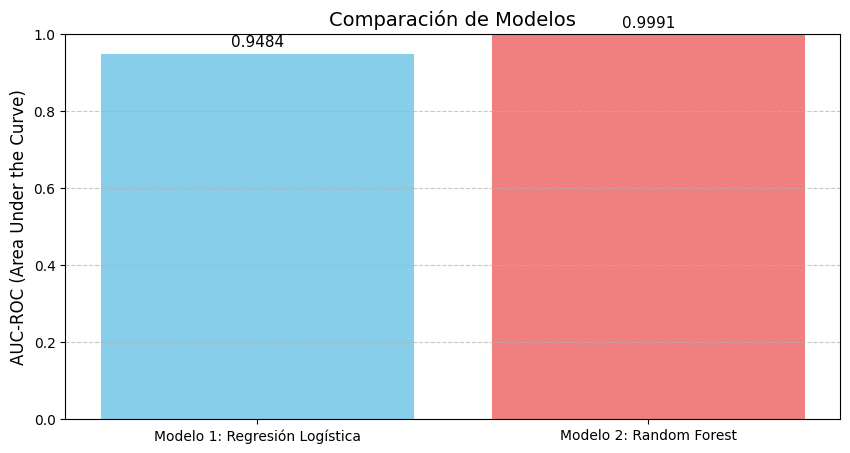

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Datos para el gráfico
modelos = ['Modelo 1: Regresión Logística', 'Modelo 2: Random Forest']
auc_metrics = [auc_lr, auc_rf]

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
bars = plt.bar(modelos, auc_metrics, color=['skyblue', 'lightcoral'])

# Etiquetas y título
plt.title('Comparación de Modelos', fontsize=14)
plt.ylabel('AUC-ROC (Area Under the Curve)', fontsize=12)
plt.ylim(0.0, 1.0) # El rango de AUC siempre es de 0 a 1

# Mostrar el valor sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()